### 플랜
1. vibrational state 고려하여 반응식 만들기 XS 데이터 활용하여 Reaction Rate계산 (Maxwellian or bi-Maxwellian?)
2. Sheath 전압에 새로운 식 사용해 보기 (현재는 C-L, collisionless)
3. Gas in-out 고려
4. Surface reaction 공부할만한 자료가 있을지..

### 수정해야할 것
1. ne나 H2+같은게 너무 빨리 올라간다는 느낌이 있다. 이것을 확인해 봐야할듯
2. Te가 빨리 떨어진다. Vs랑 연관있는듯 보인다.. (Power balance eqn)

In [19]:
#### import library ####
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import isclose

#### Experimental Setup ####
np.seterr(all='ignore')
path = 'C:/Users/GUNU/Dropbox/SNUPI/Python_Projects/Global_Model/Model_result'

kB = 1.38e-23 #[J/K] [m2 kg K-1 s-2] Boltzmann constant
kB1 = 8.617e-5 #[eV/K] Boltzmann constant
e = 1.6e-19 #[C] electronic charge
M = 1.67e-27 #[kg] mass of H atom
m = 9.1e-31 #[kg] mass of electorn
ro = 5 #[cm] radius of chamber
l = 100 #[cm] chamber length
Tg = 300 #[K] room temperature
V = np.pi*ro**2*l #[cm^3] discharge volume
A = 2*np.pi*ro*l+2*np.pi*ro**2 #[cm^2] loss area
v0 = 100*(8*Tg*kB/(M*np.pi))**0.5 #[cm/s] mean velocity of H atom
sigma_i = 5e-15 #[cm2]
g = 0.1 #Recombination Factor
LAMBDAeff = ((2.405/ro)**2+(np.pi/l)**2)**-0.5 #[cm]
D_Kn = v0 * LAMBDAeff/3 #[cm2/s]
Deff = D_Kn
T1 = LAMBDAeff**2/Deff #[s]

In [33]:
class global_model():
    #Initialization
    def __init__(self, p, input_power, duty, period, time_resolution = 1e-8):
        self.p = p
        self.input_power = input_power
        self.duty = duty
        self.period = period
        self.time_resolution = time_resolution
        
        self.ng = (self.p/7.5)/(Tg*kB)*1e-6 #[cm^-3]
        self.lambda_i = 1/(self.ng*sigma_i) #[cm] ion-neutral mean free path
        self.hl = 0.86*(3+l/2/self.lambda_i)**-0.5
        self.hR = 0.8*(4+ro/self.lambda_i)**-0.5

        self.Aeff = 2*np.pi*ro*(l*self.hR+ro*self.hl)  #[cm^2] effective area
        self.deff = V/self.Aeff #[cm]
        print('Condition : {}mTorr, {}W, {}ms, {}'.format(self.p, self.input_power/6.241509e18, self.period*1000, self.duty))
        
    #Balance equation calculate function
    def electron_balance_eqn(self, x, t, power):

        Te = x[0]
        nH = x[1]
        nHp = x[2]
        nH2p = x[3]
        nH3p = x[4]
        ne = nHp + nH2p + nH3p
        uB = np.sqrt(kB/kB1*Te/M)*100 #[cm/s] #kB/kB1 = e
        uB2 = np.sqrt(kB/kB1*Te/2/M)*100
        uB3 = np.sqrt(kB/kB1*Te/3/M)*100
        #Vs = -Te*np.log(4/ne/np.sqrt(8*e*Te/np.pi/m)*(nHp*uB+nH2p*uB2+nH3p*uB3))
        Vs = Te*np.log(np.sqrt(M/(2*np.pi*m)))
        t0 = V/self.Aeff*np.sqrt(M/(kB/kB1*Te))/100 #[s] Characteristic transit time of H+ ion 
        #k8,k9,k11의 Te가 매우 작을때의 Cross section값을 구해야한다. (k2는 괜찮음)
            
        ##### Rate coefficient calculation #####
        # ref. R. K. Janev, et al., Elementary Processes in Hydrogen-Helium Plasmas, Springer (1987)
        # H + e -> H+ + 2e, Reaction 2.1.5 E = 13.6
        k1 = np.exp(-3.271396786375e+01+1.353655609057e+01*np.log(Te)-5.739328757388e+00*(np.log(Te))**2+1.563154982022e+00*(np.log(Te))**3-2.877056004391e-01*(np.log(Te))**4+3.482559773737e-02*(np.log(Te))**5-2.631976175590e-03*(np.log(Te))**6+1.119543953861e-04*(np.log(Te))**7-2.039149852002e-06*(np.log(Te))**8)
        # H+ + e -> H + hv, Reaction 2.1.8 E = Te
        k2 = 3.92e-14*(13.6/Te)**1.5/(13.6/Te+0.35) # n = 1s
        # H2 + e -> 2H + e, Reaction 2.2.5 E = 10
        k3 = np.exp(-2.858072836568e+01+1.038543976082e+01*np.log(Te)-5.383825026583e+00*(np.log(Te))**2+1.950636494405e+00*(np.log(Te))**3-5.393666392407e-01*(np.log(Te))**4+1.006916814453e-01*(np.log(Te))**5-1.160758573972e-02*(np.log(Te))**6+7.411623859122e-04*(np.log(Te))**7-2.001369618807e-05*(np.log(Te))**8)
        # H2 + e -> H2+ + 2e, Reaction 2.2.9 E = 15.4
        k4 = np.exp(-3.568640293666e+01+1.733468989961e+01*np.log(Te)-7.767469363538e+00*(np.log(Te))**2+2.211579405415e+00*(np.log(Te))**3-4.169840174384e-01*(np.log(Te))**4+5.088289820867e-02*(np.log(Te))**5-3.832737518325e-03*(np.log(Te))**6+1.612863120371e-04*(np.log(Te))**7-2.893391904431e-06*(np.log(Te))**8)
        # H2 + e -> H+ + H + 2e, Reaction 2.2.10 E = 18
        k5 = np.exp(-3.834597006782e+01+1.426322356722e+01*np.log(Te)-5.826468569506e+00*(np.log(Te))**2+1.727940947913e+00*(np.log(Te))**3-3.598120866343e-01*(np.log(Te))**4+4.822199350494e-02*(np.log(Te))**5-3.909402993006e-03*(np.log(Te))**6+1.738776657690e-04*(np.log(Te))**7-3.252844486351e-06*(np.log(Te))**8)
        # H2+ + e -> 2H+ + 2e, Reaction 2.2.11 E = 15.5
        k6 = np.exp(-3.746192301092e+01+1.559355031108e+01*np.log(Te)-6.693238367093e+00*(np.log(Te))**2+1.981700292134e+00*(np.log(Te))**3-4.044820889297e-01*(np.log(Te))**4+5.352391623039e-02*(np.log(Te))**5-4.317451841436e-03*(np.log(Te))**6+1.918499873454e-04*(np.log(Te))**7-3.591779705419e-06*(np.log(Te))**8)
        # H2+ + e -> H+ + H + e, Reaction 2.2.12 E = 10.5
        k7 = np.exp(-1.781416067709e+01+2.277799785711e+00*np.log(Te)-1.266868411626e+00*(np.log(Te))**2+4.296170447419e-01*(np.log(Te))**3-9.609908013189e-02*(np.log(Te))**4+1.387958040699e-02*(np.log(Te))**5-1.231349039470e-03*(np.log(Te))**6+6.042383126281e-05*(np.log(Te))**7-1.247521040900e-06*(np.log(Te))**8)
        # H2+ + e -> 2H, Reaction 2.2.14 E = Te
        k8 = np.exp(-1.670435653561e+01-6.035644995682e-01*np.log(Te)-1.942745783445e-08*(np.log(Te))**2-2.005952284492e-07*(np.log(Te))**3+2.962996104431e-08*(np.log(Te))**4+2.134293274971e-08*(np.log(Te))**5-6.353973401838e-09*(np.log(Te))**6+6.152557460831e-10*(np.log(Te))**7-2.025361858319e-11*(np.log(Te))**8)
        # H3+ + e -> H2 + H, Reaction 2.2.15 E = Te
        k9 = np.exp(-1.700270758355e+01-4.050073042947e-01*np.log(Te)+1.018733477232e-08*(np.log(Te))**2-1.695586285687e-08*(np.log(Te))**3+1.564311217508e-10*(np.log(Te))**4+1.979725412288e-09*(np.log(Te))**5-4.395545994733e-10*(np.log(Te))**6+3.584926377078e-11*(np.log(Te))**7-1.024189019465e-12*(np.log(Te))**8)
        # H3+ + e -> H+ + 2H + e, Reaction 2.2.16 E = 14
        k10 = np.exp(-3.078408636631e+01+1.509421488513e+01*np.log(Te)-7.349167207324e+00*(np.log(Te))**2+2.320966107642e+00*(np.log(Te))**3-4.818077551719e-01*(np.log(Te))**4+6.389229162737e-02*(np.log(Te))**5-5.161880953089e-03*(np.log(Te))**6+2.303985092606e-04*(np.log(Te))**7-4.344846146197e-06*(np.log(Te))**8)
        # H2+ + H2 -> H3+ + H, Reaction 4.3.3 E = 0
        k11 = 2.1e-9
        
        if Te < 0.025:
            # H+ + e -> H + hv, Reaction 2.1.8 E = Te
            k2 = 9.137053951846942e-13
            # H2+ + e -> 2H Janev++ 73p
            k8 = 5.156170153467892e-07
            # H3+ + e -> H2 + H Janev++ 98p
            k9 = 1.8393447268390669e-07
            
        ##### Energy Loss per Reaction #####
        E1 = 13.6
        E2 = Te
        E3 = 10
        E4 = 15.4
        E5 = 18
        E6 = 15.5
        E7 = 10.5
        E8 = Te
        E9 = Te
        E10 = 14
        E11 = 0
        E12 = 12.1

        #Quasi-Neutrality eqn
        ne = nHp + nH2p + nH3p

        #Hydrogen atom conservation eqn
        nH2 = self.ng - (0.5*(nH+nHp)+nH2p+1.5*nH3p)

        #Particle balance eqn for electron
        dne_dt = (k1*ne*nH)+(k4*ne*nH2)+(k5*ne*nH2)+(k6*ne*nH2p)-(k2*ne*nHp)-(k8*ne*nH2p)-(k9*ne*nH3p)-ne*uB*self.Aeff/V
        
        #Power balance eqn for electron
        dTe_dt = 2/(3*ne)*(self.power(t)/V - (Vs+2.5*Te)*ne*uB*self.Aeff/V - 3/2*Te*dne_dt \
        - (k1*nH*E1*ne + k2*nHp*E2*ne + k3*nH2*E3*ne + k4*nH2*E4*ne + k5*nH2*E5*ne + k6*nH2p*E6*ne + k7*nH2p*E7*ne \
        + k8*nH2p*E8*ne + k9*nH3p*E9*ne + k10*nH3p*E10*ne + k11*nH2p*E11*nH2))
        
        #Particle balance eqn for other species except electron
        dnH_dt = +(k2*nHp*ne)+2*(k3*nH2*ne)+(k5*nH2*ne)+(k7*nH2p*ne)+2*(k8*nH2p*ne)\
        +(k9*nH3p*ne)+2*(k10*nH3p*ne)+(k11*nH2p*nH2)+(nHp/(t0))+(nH3p/(np.sqrt(3)*t0))-(k1*ne*nH)-(nH*g/T1)
        
        dnHp_dt = (k1*ne*nH)+(k5*nH2*ne)+2*(k6*nH2p*ne)+(k10*nH3p*ne)-(k2*nHp*ne)-(nHp/(t0))
        
        dnH2p_dt = (k4*nH2*ne)-(k6*nH2p*ne)-(k7*nH2p*ne)-(k8*nH2p*ne)-(k11*nH2p*nH2)-(nH2p/(np.sqrt(2)*t0))
        
        dnH3p_dt = (k11*nH2p*nH2)-(k9*nH3p*ne)-(k10*nH3p*ne)-(nH3p/(np.sqrt(3)*t0))

        return [dTe_dt, dnH_dt, dnHp_dt, dnH2p_dt, dnH3p_dt]
        
    #Pulsed power generate function
    def power(self,t):
        if t <= self.duty*self.period:
            return self.input_power
        else:
            return 0
        
    #Temperature & Density Calculation
    def calculation(self):
        x0 = [0.026,1e2,1e2,1e2,1e2] #Te, H, H+, H2+, H3+
        #x0 = [0.026,0,0,0,0]
        self.t = np.linspace(0, self.period, int(self.period/self.time_resolution))
        args = (self.power,)
        ans1 = odeint(self.electron_balance_eqn, x0, self.t, args, rtol=10**-3, mxstep=10**6)
        self.T = ans1[:,0]
        self.H = ans1[:,1]
        self.Hp = ans1[:,2]
        self.H2p = ans1[:,3]
        self.H3p = ans1[:,4]
        self.ne = self.Hp + self.H2p + self.H3p
        self.H2 = self.ng-(0.5*(self.H+self.Hp)+self.H2p+1.5*self.H3p)
        
    #Iteration
    def iteration(self):
        self.iteration_number = 0
        H3p_compare = 1
        Hp_compare = 1
        H2p_compare = 1
        while(not isclose(self.H2p[-1], H2p_compare, rel_tol=1e-2) or not isclose(self.H3p[-1], H3p_compare, rel_tol=1e-2) or not isclose(self.Hp[-1], Hp_compare, rel_tol =1e-2)):
            if self.iteration_number > 150:
                print('did not converge')
                break
            x0 = [self.T[-1], self.H[-1], self.Hp[-1], self.H2p[-1], self.H3p[-1]] #Te, nH, nHp, nH2p, nH3p
            args = (self.power,)
            H2p_compare = self.H2p[-1]
            H3p_compare = self.H3p[-1]
            Hp_compare = self.Hp[-1]
            ans2 = odeint(self.electron_balance_eqn, x0, self.t, args, rtol=10**-2, mxstep=10**3)
            self.T = np.append(self.T, ans2[:,0])
            self.H = np.append(self.H, ans2[:,1])
            self.Hp = np.append(self.Hp, ans2[:,2])
            self.H2p = np.append(self.H2p, ans2[:,3])
            self.H3p = np.append(self.H3p, ans2[:,4])
            self.ne = self.Hp + self.H2p + self.H3p
            self.H2 = self.ng - (0.5*(self.H+self.Hp)+self.H2p+1.5*self.H3p)
            self.iteration_number += 1
        print('iteration count :' + str(self.iteration_number))
        print('---------------------------------------')
        self.t_long = np.linspace(0, (self.iteration_number+1)*self.period-self.time_resolution, (self.iteration_number+1)*int(self.period/self.time_resolution))
        self.data = np.vstack([self.H,self.Hp,self.H2p,self.H3p,self.ne,self.H2,self.T])
        
    #Visualization
    def visualization1(self,i):
        plt.figure(figsize=(16,16))
        Power_list = []
        for i in self.t:
            Power_list.append(self.power(i)/6.241509e18)
    
        plt.subplot(421)
        plt.plot(self.t*1e6,self.T)
        plt.xlabel('Time (us)')
        plt.ylabel('Temperature (eV)')
        #plt.xlim(440,560)
        #plt.ylim(0,10)
        plt.title('Electron Temperature')
        plt.grid(True)

        plt.subplot(422)
        plt.plot(self.t*1e6,self.ne,'brown')
        plt.yscale('log')
        plt.xlabel('Time (us)')
        plt.ylabel('Density (cm-3)')
        plt.title('Electron Density')
        plt.grid(True)
        plt.subplots_adjust(hspace = 0.5)
        plt.savefig(path + str(i) + 'vis1.png')
        plt.show()
          
    def visualization2(self): 
        plt.figure(figsize=(16,10))
        plt.plot(self.t_long*1e6,self.H,self.t_long*1e6,self.Hp,self.t_long*1e6,self.H2,self.t_long*1e6,self.H2p,self.t_long*1e6,self.H3p,self.t_long*1e6,self.ne)
        plt.yscale('log')
        plt.xlabel('Time (us)')
        plt.ylabel('Density (cm-3)')
        #plt.ylim(1e8,1e16)
        plt.legend(['H','H+','H2','H2+','H3+','e'],loc = 'upper right')
        plt.title('Density of All Species')
        plt.grid(True)
        plt.savefig(path + 'vis2.png')
        plt.show()
        
    def visualization3(self):
        legend_list=['H','H+','H2+','H3+','Electron']
        color_list = ['tab:blue','tab:orange','tab:red','tab:purple','tab:brown']
        start = int(self.iteration_number*self.period/self.time_resolution)
        end = int((self.iteration_number+1)*self.period/self.time_resolution)-1
        
        plt.figure(figsize=(16,10))
        for i in range(5):
            plt.subplot(4,2,i+1)
            plt.plot(self.t_long[start:end]*1e6,self.data[i][start:end],color_list[i])
            plt.yscale('log')
            plt.xlabel('Time (us)')
            plt.ylabel('Density (cm-3)')
            plt.legend([legend_list[i]], loc = 'upper right')
            #plt.ylim(1e8,1e16)
            plt.grid(True)
        plt.savefig(path + 'vis3-1.png')
        
        plt.figure(figsize=(8,5))
        plt.plot(self.t_long[start:end]*1e6,self.H[start:end],'tab:blue',self.t_long[start:end]*1e6,self.Hp[start:end],'tab:orange'\
                 ,self.t_long[start:end]*1e6,self.H2p[start:end],'tab:red',self.t_long[start:end]*1e6,self.H3p[start:end],'tab:purple'\
                 ,self.t_long[start:end]*1e6,self.ne[start:end],'tab:brown',self.t_long[start:end]*1e6,self.H2[start:end],'tab:green')
        plt.yscale('log')
        plt.xlabel('Time (us)')
        plt.ylabel('Density (cm-3)')
        plt.title('Density of All Species')
        plt.legend(legend_list, loc = 'upper right')
        plt.grid(True)
        plt.savefig(path + 'vis3-2.png')
        plt.show()
        
    def data_process(self):
        data = np.vstack([self.H,self.Hp,self.H2,self.H2p,self.H3p,self.ne,self.T]).T
        data = pd.DataFrame(data, index = self.t_long*1e6)
        data.columns= ['H','H+','H2','H2+','H3+','ne','Te']
        data.index.name='Time[us]'
        #data.to_csv('Result.csv')
        idx = []
        for i in range(self.iteration_number+1):
            idx.append(int(self.period/self.time_resolution*(i+1)-1))
        Hp_frac = self.Hp[-1]/self.ne[-1]
        H2p_frac = self.H2p[-1]/self.ne[-1]
        H3p_frac = self.H3p[-1]/self.ne[-1]
        self.frac_data = [Hp_frac, H2p_frac, H3p_frac,self.T[-1],self.ne[-1]]
        #print('{},{},{},{},{}'.format(Hp_frac,H2p_frac,H3p_frac,self.T[-1],self.ne[-1]*1e-12))
        
        return data.iloc[idx[-1]], data.iloc[idx], self.frac_data

In [34]:
def DataCollecting(variable):
    result = pd.Series([])
    frac_result = []
    if variable == 'p':
        i_list = p_list
        file_name = 'p variable ' + str(input_power/6.241509e18)+'W '+str(period*1000)+'ms ' + str(duty)
    elif variable == 'input_power':
        i_list = input_list
        file_name = 'input_power variable ' + str(p) + 'mTorr ' +str(period*1000)+'ms ' + str(duty)
    elif variable == 'duty':
        i_list = duty_list
        file_name = 'duty variable ' + str(p) + 'mTorr ' + str(input_power/6.241509e18)+'W '+str(period*1000)+'ms '
    elif variable == 'period':
        i_list = period_list
        file_name = 'period variable ' + str(p) + 'mTorr ' + str(input_power/6.241509e18)+'W ' + str(duty)
    else:
        print('Please put right variable name')
        return False
    
    for i in i_list:
        if variable == 'p':
            model = global_model(i, input_power, duty, period)
        if variable == 'input_power':
            model = global_model(p, i, duty, period)
        if variable == 'duty':
            model = global_model(p, input_power, i, period)
        if variable == 'period':
            model = global_model(p, input_power, duty, i)
        model.calculation()
        #model.visualization1()
        model.iteration()
        #model.visualization3()
        tmp = model.data_process()[0]
        frac_tmp = model.data_process()[2]
        frac_result += frac_tmp
        result = pd.concat([result,tmp],axis=1)
        print('ne: ',model.ne[-1])
        print('Te: ',model.T[-1])
        
    frac_result = np.array(frac_result).reshape(len(i_list),5)
    frac_result = pd.DataFrame(frac_result,columns=['H+','H2+','H3+','Te','ne'],index=i_list)
    result = result.drop(0, axis=1)
    if variable == 'input_power':
        result.columns = i_list/6.241509e18
        frac_result.index = i_list/6.241509e18
    else:
        result.columns = i_list
        frac_result.index = i_list
    #path = r'Model_result\\'
    result.to_csv(path+file_name + '.csv')
    frac_result.to_csv(path+'frac_'+file_name + '.csv')

    return result, frac_result

In [35]:
#### Control Variables ####
p = 5 #[mTorr] Pressure
input_power = 2000*6.241509e18 #[eV/s] Input Power
duty = 0.5
period = 1e-4
time_resolution = 1e-7

input_list = np.arange(500,4250,250)*6.241509e18
#p_list = np.array([5,7,10,15,20])
p_list = np.arange(1.5,20.5,0.5)
duty_list = np.linspace(0.1,1,100)
period_list = np.array([1e-3,2e-3,4e-3,5e-3,7e-3,8e-3,9e-3,10e-3])

Condition : 5mTorr, 2000.0W, 0.1ms, 0.5


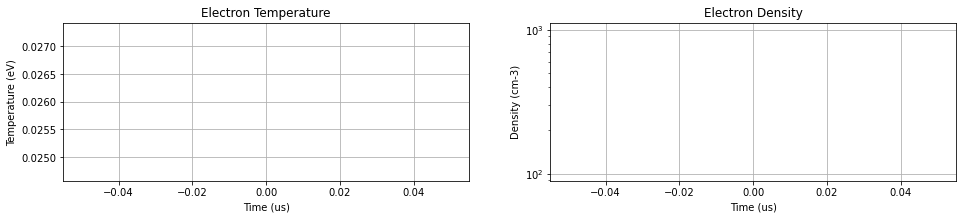

did not converge
iteration count :151
---------------------------------------


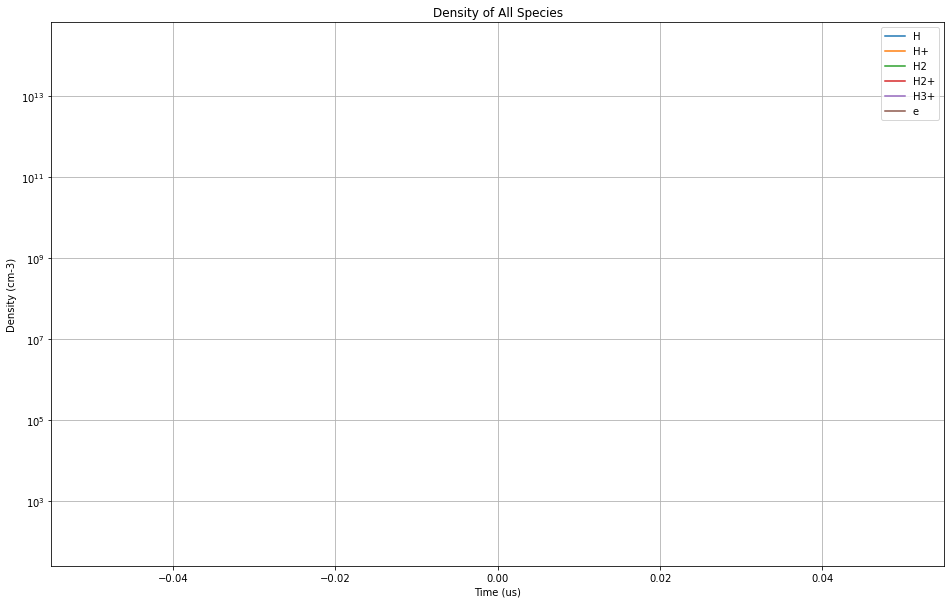

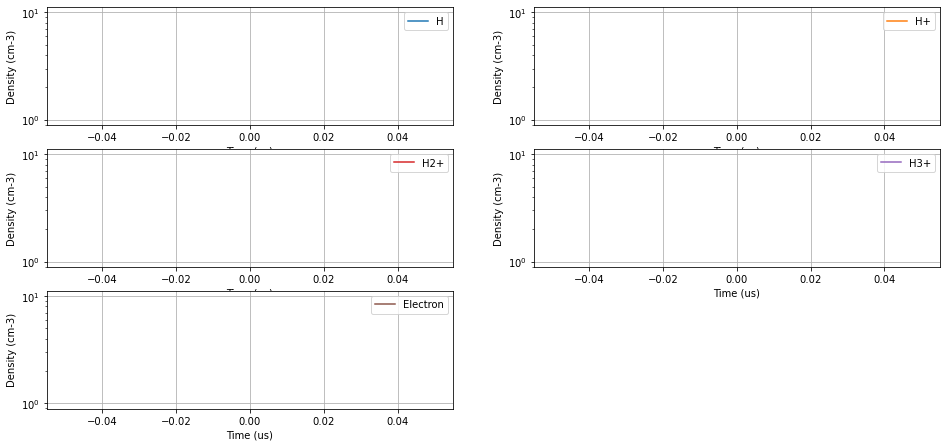

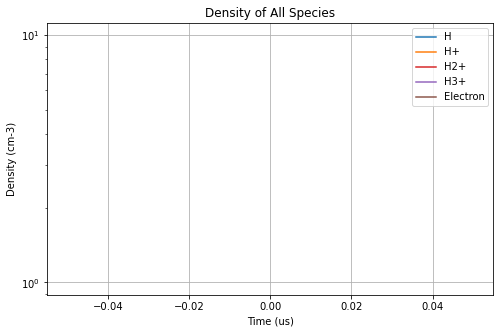

In [36]:
#### Test Calculation ####
model1 = global_model(p,input_power, duty, period, time_resolution)
try:
    model1.calculation()
    model1.visualization1(1)
    model1.iteration()
    model1.visualization2()
    model1.visualization3()
except BaseException:
    pass
#model1.data_process()

Condition : 5mTorr, 500.0W, 0.1ms, 0.5


c:\users\gunu\anaconda3\envs\py_36\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/metyu/Dropbox/SNUPI/Python_Projects/Global_Model/Model_result0.0001vis1.png'

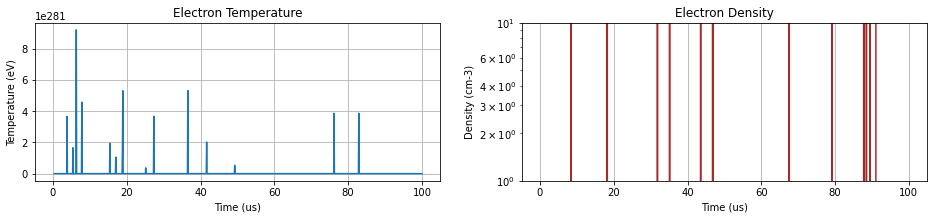

In [18]:
for i in range(1,7):
    input_power = 500*6.241509e18 #[eV/s] Input Power
    models = [0,0,0,0,0,0,0]
    models[i] = global_model(p, input_power*i, duty, period, time_resolution)
    models[i].calculation()
    models[i].visualization1(i)

In [ ]:
#### Calcultation & Data collection ####
variable = input('Please select variables you want to change\n')
DataCollecting(variable)

In [27]:
#### Power finder ####
collection = []
power_list = []
input_power = 16200*6.241509e18
for p in p_list:
    ne_compare = 1
    while(not isclose(1e12,ne_compare,rel_tol=1e-2)):

        input_power -= 10*6.241509e18
        model1 = global_model(p,input_power, duty, period, time_resolution)
        model1.calculation()
        #model1.visualization1()
        model1.iteration()
        #model1.visualization2()
        #model1.visualization3()
        model1.data_process()
        ne_compare = model1.ne[-1]
        print(input_power/6.241509e18)
    power_list.append(input_power)
    print('found it')
    collection += model1.frac_data
    
collection = np.array(collection).reshape(len(p_list),5)
collection = pd.DataFrame(collection)
path = r'Model_result\\'
collection.to_csv(path+'collection' + '.csv')

Condition : 1.5mTorr, 16190.0W, 0.01ms, 0.5
iteration count :22
---------------------------------------
16190.0
Condition : 1.5mTorr, 16180.0W, 0.01ms, 0.5
iteration count :21
---------------------------------------
16180.0
Condition : 1.5mTorr, 16170.000000000002W, 0.01ms, 0.5


KeyboardInterrupt: 

In [ ]:
### Optimizer ### 총 곱이 1e-1*1e-5*5000이 되게 즉 5e-3이 되게. 1*5*e-5*100W?
optim_result = []
for p_op in np.arange(2,21,1):
    for duty_op in np.arange(0.1,1.0,0.1): #duty variation
        for period_op in np.arange(1e-5,6e-5,1e-5):#period variation
            power_op = 5e-3/duty_op/period_op
            model_tmp = global_model(p_op, power_op*6.241509e18,duty_op,period_op, time_resolution)
            try:
                model_tmp.calculation()
                model_tmp.iteration()
            except Exception:
                pass
            frac_data = model_tmp.data_process()[2]
            data = [power_op,p_op,duty_op,period_op]+frac_data
            optim_result.append(data)
len_optim = len(optim_result)
optim_result = np.array(optim_result)
optim_result = pd.DataFrame(optim_result)
path = r'Model_result\\'
optim_result.to_csv(path+'new_optimizer_result'+'.csv')